## CUSTOMER ANALYSIS

In [2]:
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from IPython.display         import Image
from sklearn.tree import export_text
from sklearn.metrics import classification_report
from sklearn.preprocessing import RobustScaler

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math
import pydotplus         as pdp
import numpy as np
import hdbscan

In [3]:
import os
os.getcwd()


'd:\\TAI LIEU\\KHAI PHÁ DỮ LIỆU\\ĐỒ ÁN CUỐI KỲ\\DM\\notebooks'

In [4]:
df= pd.read_csv("../data/processed/bank_marketing_raw.csv")

In [5]:
cus_df = df[['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'target']]

In [6]:
for col in cus_df.columns:
    print(f"\n===== Column: {col} =====")
    pct = pd.crosstab(df[col], df['target'], normalize='index').sort_values(by = [1], ascending=[False])
    print(pct.round(3))


===== Column: age =====
target      0      1
age                 
90      0.000  1.000
92      0.000  1.000
93      0.000  1.000
85      0.200  0.800
87      0.250  0.750
..        ...    ...
44      0.918  0.082
50      0.923  0.077
88      1.000  0.000
89      1.000  0.000
94      1.000  0.000

[77 rows x 2 columns]

===== Column: job =====
target             0      1
job                        
student        0.713  0.287
retired        0.772  0.228
unemployed     0.845  0.155
management     0.862  0.138
admin.         0.878  0.122
self-employed  0.882  0.118
technician     0.889  0.111
services       0.911  0.089
housemaid      0.912  0.088
entrepreneur   0.917  0.083
blue-collar    0.927  0.073

===== Column: marital =====
target        0      1
marital               
single    0.851  0.149
divorced  0.881  0.119
married   0.899  0.101

===== Column: education =====
target         0      1
education              
tertiary   0.850  0.150
secondary  0.894  0.106
primary    0.914  0

## ĐƠN BIẾN

### AGE

**Phân nhóm độ tuổi theo giai đoạn vòng đời tài chính của khách hàng**

Các nhóm tuổi được chia thành các giai đoạn trong cuộc đời với:
- Formative Years: từ 0 đến 18 tuổi
- Early Career: từ 18 đến 25 tuổi
- Mid-Career: từ 25 đến 45 tuổi
- 'Pre-Retirement: từ 45 đến 65 tuổi
- Retirement: 65 tuổi trở lên

Phân chia tuổi khách hàng theo phương pháp này cho thấy sự **thiên lệch** trong số lượng khách hàng ở mỗi nhóm tuổi khi nhóm Mid-Career chiếm hơn 65% toàn bộ khách hàng, nhóm Pre-Retirement chiếm khoảng 30%. Trong khi tổng khách hàng trong 3 nhóm tuổi còn lại chỉ chiếm 5%


In [7]:
cus_df['age_group_1'] = pd.cut(cus_df['age'], bins= [0, 18, 25, 45, 65, 120],
                             labels= ['Formative Years', 'Early Career', 'Mid-Career', 'Pre-Retirement', 'Retirement'],
                             right= True)
ag1_count = cus_df.groupby('age_group_1').size()
ag1_count = pd.DataFrame(ag1_count).reset_index()
ag1_count


C:\Users\ACER\AppData\Local\Temp\ipykernel_23884\234245647.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cus_df['age_group_1'] = pd.cut(cus_df['age'], bins= [0, 18, 25, 45, 65, 120],
C:\Users\ACER\AppData\Local\Temp\ipykernel_23884\234245647.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ag1_count = cus_df.groupby('age_group_1').size()


,age_group_1,0
0,Formative Years,12
1,Early Career,1324
2,Mid-Career,29427
3,Pre-Retirement,13697
4,Retirement,751


**Nhận xét:**

Tỷ lệ thành công của chiến dịch ở nhóm Formative Years là cao nhất với 58%. Kế đến là nhốm Retirement và Early Career với 43% và 24%. Hai nhóm tuổi Pre-Retirement và Mid-Career chỉ đạt tỷ lệ thành công ở mức 11%.

Khi phân nhóm độ tuổi theo chu kỳ tài chính, số lượng khách hàng giữa các nhóm có sự chênh lệch đáng kể. Mặc dù chu kỳ tài chính phù hợp cho mục đích diễn giải, nhưng chưa tối ưu để đánh giá hiệu quả chiến dịch do sự mất cân bằng về phân bố mẫu. Vì vậy, bên cạnh tỷ lệ thành công, cần xem xét thêm các thước đo chuẩn hóa khác để đánh giá toàn diện hơn tác động của độ tuổi đến khả năng subscribe deposit.

In [8]:

pct_age = pd.crosstab(cus_df['age_group_1'], cus_df['target'], 
                      normalize='index').sort_values(by= 1, ascending=False).round(2)
pct_age = pd.DataFrame(pct_age.reset_index())

pct_age

target,age_group_1,0,1
0,Formative Years,0.42,0.58
1,Retirement,0.57,0.43
2,Early Career,0.76,0.24
3,Pre-Retirement,0.89,0.11
4,Mid-Career,0.89,0.11


Text(0.5, 1.0, 'Subcription Rate By Age Group')

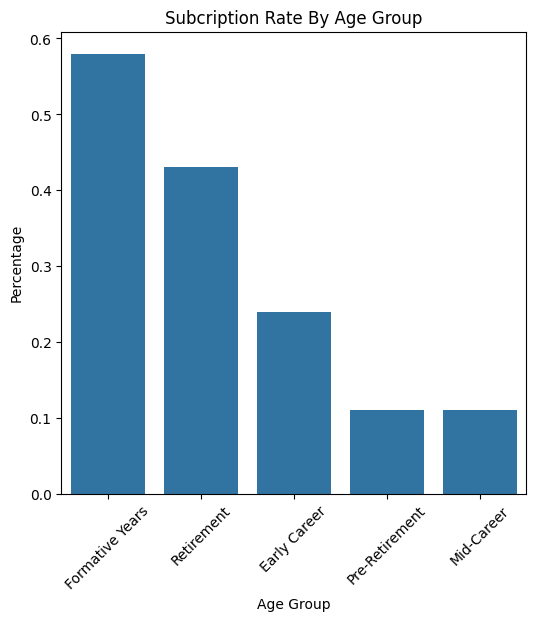

In [9]:
order = pct_age.sort_values(by=1, ascending=False)['age_group_1']
plt.figure(figsize=(6, 6))
sns.barplot(data= pct_age, x= 'age_group_1', y= 1, order=order)
plt.tick_params(axis='x', rotation= 45)
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.title('Subcription Rate By Age Group')

**Phân nhóm độ tuổi sử dụng Decision Tree nhằm xác định các ngưỡng phân tách tối ưu theo dữ liệu**

In [10]:
age_tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.05)
age_tree.fit(df[['age']], df['target'])


,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",4
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",0.05
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",None
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the curre


(process:21032): Pango-CRITICAL **: 07:45:25.208: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:21032): Pango-CRITICAL **: 07:45:25.209: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:21032): Pango-CRITICAL **: 07:45:25.209: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:21032): Pango-CRITICAL **: 07:45:25.209: pango_font_description_get_family: assertion 'desc != NULL' failed



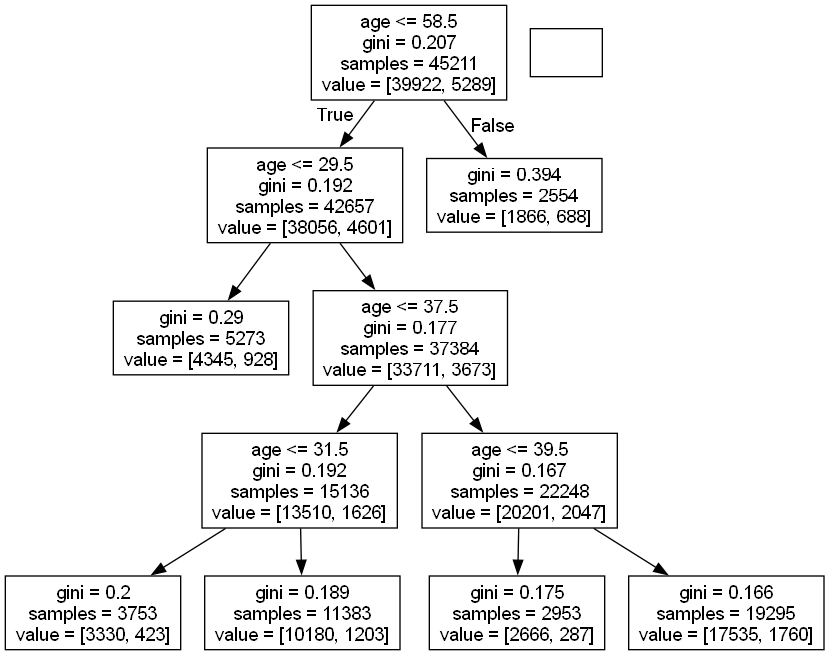

In [11]:
## Biểu diễn cây quyết định
dcs_tree = tree.export_graphviz(age_tree, out_file = None, feature_names = ['age'])
graph    = pdp.graph_from_dot_data(dcs_tree)
Image(graph.create_png())

**Nhận xét:**

Từ kết quả của Cây quyết định, độ tuổi khách hàng được chia thành 4 nhóm:
- Từ 0 đến 29 tuổi (chiếm 12%)
- Từ 29 tuổi đến 37 tuổi (chiếm 33%)
- Từ 37 tuổi đến 58 tuổi (chiếm 49%)
- Trên 58 tuổi (chiếm 6%)

In [12]:
cus_df.loc[:,'age_group_2'] = pd.cut(cus_df.loc[:,'age'], bins= [0, 29.5, 37.5, 58.5, 120],
                             labels= ['< 29', '29 - 37', '37-58', '> 58'],
                             right= True)
ag2_count = cus_df.groupby('age_group_2', observed=True).size()
ag2_count = pd.DataFrame(ag2_count).reset_index()
ag2_count

C:\Users\ACER\AppData\Local\Temp\ipykernel_23884\1322626860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cus_df.loc[:,'age_group_2'] = pd.cut(cus_df.loc[:,'age'], bins= [0, 29.5, 37.5, 58.5, 120],


,age_group_2,0
0,< 29,5273
1,29 - 37,15136
2,37-58,22248
3,> 58,2554


**Nhận xét:**

Nhóm khách hàng trên 58 tuổi có tỷ lệ đăng ký tiền gửi có kỳ hạn cao nhất, rơi vào 27%

Nhóm khách hàng dưới 29 tuổi có tỷ lệ đăng ký tiền gửi có kỳ hạn khoảng 18%

Các nhóm 29-37 tuổi và 37-58 tuối chỉ đạt tỷ lệ 11% và 9%

--> Nhóm khách hàng trên 58 tuổi có xu hướng đăng ký cao hơn, tuy nhiên mối quan hệ giữa độ tuổi và khả năng đăng ký tiền gửi có kỳ hạn vẫn là chưa rõ ràng

--> Độ tuổi chỉ đóng vai trò hỗ trợ trong phân tích và cần được kết hợp với các biến khác để đánh giá hiệu quả toàn diện hơn

In [13]:
pct_age = pd.crosstab(cus_df['age_group_2'], cus_df['target'], 
                      normalize='index').sort_values(by= 1, ascending=False).round(2)
pct_age = pd.DataFrame(pct_age.reset_index())
pct_age

target,age_group_2,0,1
0,> 58,0.73,0.27
1,< 29,0.82,0.18
2,29 - 37,0.89,0.11
3,37-58,0.91,0.09


Text(0.5, 1.0, 'Subcription Rate By Age Group')

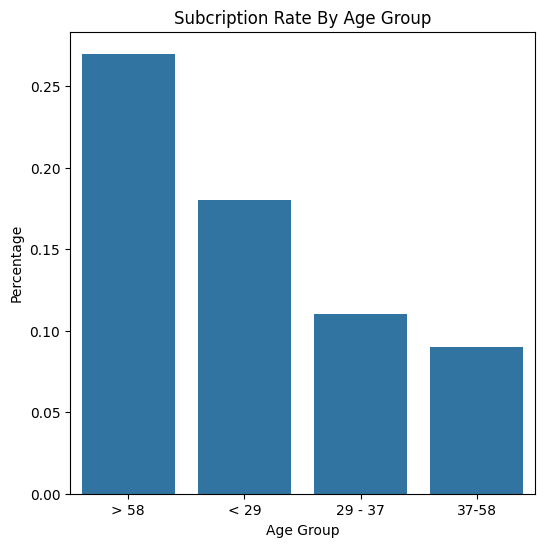

In [14]:
order = pct_age.sort_values(by=1, ascending=False)['age_group_2']
plt.figure(figsize=(6, 6))
sns.barplot(data= pct_age, x= 'age_group_2', y= 1, order=order)
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.title('Subcription Rate By Age Group')

### BALANCE

**Phân nhóm số dư tài khoản bằng optimal binning**

Biến số dư tài khoản được chia khoảng bằng phương pháp optimal binning nhằm tối đa hóa sự khác biệt về tỷ lệ đăng ký tiền gửi giữa các nhóm

Số dư tài khoản của khách hàng được chia thành các khoảng:
- Từ vô cùng đến - 46.5
- Từ -46.5 đến 60.5
- Từ 60.5 đến 798.5
- Từ 798.5 đến 1578.5
- Lớn hơn 1578.5

Các khoảng chia này cho thấy event rate (tỷ lệ khách hàng đăng ký) ở các bin phân biệt rõ với nhau và tăng đều theo bin

Kích thước của các bin cũng là hợp lý, bin lớn nhất chiến khoảng 39% - vẫn chấp nhận được

Không có hiện tượng thiên lệch mẫu khi bin có event rate cao nhất vẫn có mức count chỉ khoảng 23%


In [15]:
from optbinning import OptimalBinning

optb = OptimalBinning(
    name="balance",
    dtype="numerical",
    max_n_bins=5
)

optb.fit(cus_df['balance'], cus_df['target'])

binning_table = optb.binning_table.build()
binning_table


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, -46.50)",3193,0.070624,3027,166,0.051989,0.882041,0.039195,0.004747
1,"[-46.50, 60.50)",7628,0.168720,7034,594,0.077871,0.450333,0.028770,0.003566
2,"[60.50, 798.50)",17577,0.388777,15614,1963,0.111680,0.052396,0.001046,0.000131
3,"[798.50, 1578.50)",6369,0.140873,5521,848,0.133145,-0.147865,0.003259,0.000407
4,"[1578.50, inf)",10444,0.231006,8726,1718,0.164496,-0.396152,0.042091,0.005227
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,45211,1.000000,39922,5289,0.116985,,0.114360,0.014078


**Nhận xét**

Nhóm khách hàng có số dư tài khoản trên 1578.5 có tỷ lệ đăng ký tiền gửi có kỳ hạn cao nhất với 16%

Tỷ lệ đăng ký có xu hướng tăng dần theo mức số dư tài khoản, từ 5% ở mức thấp nhất lên đến khoảng 16% ở nhóm có số dư cao

--> Balance có mối liên hệ tích cực với khả năng đăng ký tiền gửi. Tuy nhiên mức chênh lệch giữa các nhóm là không quá lớn, cho thấy balance không phải là yếu tố duy nhất ảnh hưởng đến quyết định của khách hàng

In [16]:
cus_df.loc[:, 'balance_group'] = pd.cut(cus_df.loc[:, 'balance'], bins= [-9999, -46.5, 60.5, 798.5, 1578.5, 99999999],
                                 labels= ['< -46.5', '-46.5 - 60.5', '60.5 - 798.5', '798.5 - 1578.5', '> 1578.5'],
                                 right= False)

pct_balance = pd.crosstab(cus_df['balance_group'], cus_df['target'], 
                      normalize='index').sort_values(by= 1, ascending=False).round(2)
pct_balance = pd.DataFrame(pct_balance.reset_index())
pct_balance

C:\Users\ACER\AppData\Local\Temp\ipykernel_23884\5369981.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cus_df.loc[:, 'balance_group'] = pd.cut(cus_df.loc[:, 'balance'], bins= [-9999, -46.5, 60.5, 798.5, 1578.5, 99999999],


target,balance_group,0,1
0,> 1578.5,0.84,0.16
1,798.5 - 1578.5,0.87,0.13
2,60.5 - 798.5,0.89,0.11
3,-46.5 - 60.5,0.92,0.08
4,< -46.5,0.95,0.05


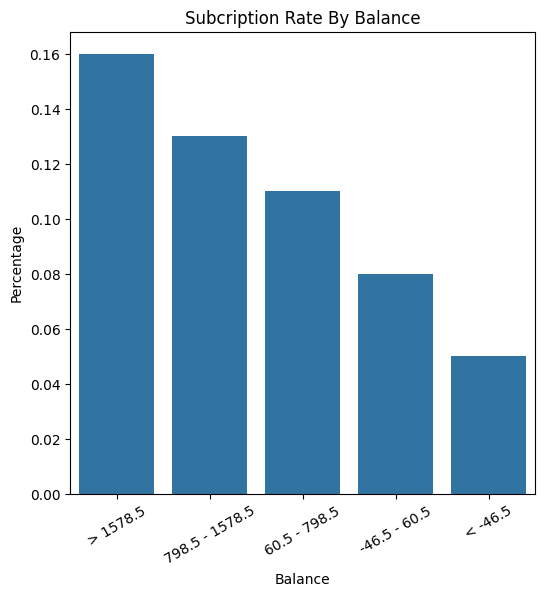

In [17]:
order = pct_balance.sort_values(by=1, ascending=False)['balance_group']
plt.figure(figsize=(6, 6))
sns.barplot(data= pct_balance, x= 'balance_group', y= 1, order=order)
plt.xlabel('Balance')
plt.ylabel('Percentage')
plt.title('Subcription Rate By Balance')
plt.tick_params(axis= 'x', rotation= 30)

### JOB

In [18]:
pct_job = pd.crosstab(
    cus_df['job'],
    cus_df['target'],
    normalize='index'
).round(3).reset_index()

pct_job = pct_job.sort_values(by=1, ascending=False)
pct_job


target,job,0,1
8,student,0.713,0.287
5,retired,0.772,0.228
10,unemployed,0.845,0.155
4,management,0.862,0.138
0,admin.,0.878,0.122
6,self-employed,0.882,0.118
9,technician,0.889,0.111
7,services,0.911,0.089
3,housemaid,0.912,0.088
2,entrepreneur,0.917,0.083


**Nhận xét**

Kết quả cho thấy nghề nghiệp có mối liên hệ rõ ràng với khả năng đăng ký tiền gửi có kỳ hạn. Nhóm *student* và *retired* có tỷ lệ đăng ký cao nhất (28.7% và 22.8%), trong khi các nhóm như *blue-collar*, *entrepreneur* và *services* có tỷ lệ đăng ký thấp nhất, chỉ khoảng 7–9%. Mức chênh lệch đáng kể giữa các nhóm nghề cho thấy hành vi tài chính của khách hàng khác nhau theo nghề nghiệp. Tuy nhiên, đây mới là phân tích đơn biến, do đó cần tiếp tục xem xét nghề nghiệp trong mối quan hệ kết hợp với các biến khác, đặc biệt là độ tuổi, để đánh giá đầy đủ vai trò của biến này.


Text(0.5, 1.0, 'Subscription Rate by Job')

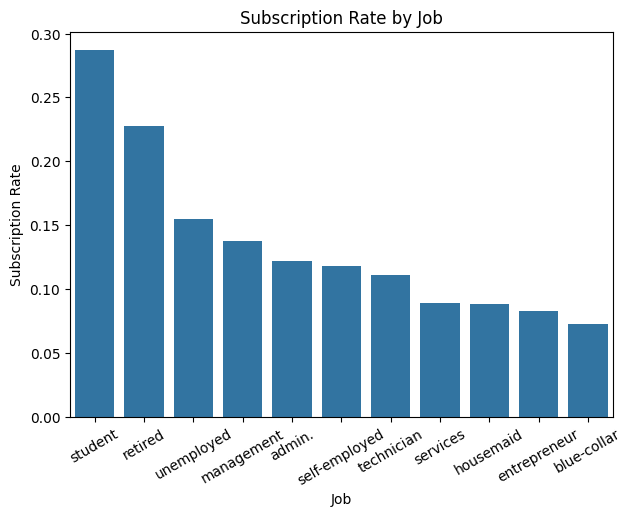

In [19]:
plt.figure(figsize=(7,5))
sns.barplot(
    data=pct_job,
    x='job',
    y=1,
    order=pct_job['job']
)
plt.xticks(rotation=30)
plt.xlabel('Job')
plt.ylabel('Subscription Rate')
plt.title('Subscription Rate by Job')


### HOUSING

In [20]:
housing_df = cus_df[['housing', 'target']].copy()
housing_dist = housing_df['housing'].value_counts(normalize=True).round(3)
housing_dist

housing
yes    0.556
no     0.444
Name: proportion, dtype: float64

In [21]:
pct_housing = pd.crosstab(
    housing_df['housing'],
    housing_df['target'],
    normalize='index'
).round(3)

pct_housing


target,0,1
housing,,
no,0.833,0.167
yes,0.923,0.077


**Housing  Analysis**

Xét theo tỷ lệ đăng ký tiền gửi có kỳ hạn (target = 1):

- Nhóm **không có vay mua nhà** đạt tỷ lệ đăng ký **16.7%**
- Nhóm **có vay mua nhà** chỉ đạt **7.7%**

Sự chênh lệch đáng kể này cho thấy **home loan có mối quan hệ nghịch với khả năng đăng ký tiền gửi có kỳ hạn**. Khách hàng đang gánh khoản vay mua nhà thường có **dòng tiền nhàn rỗi thấp hơn**, do đó ít có xu hướng tham gia các sản phẩm tiết kiệm dài hạn.

Tuy nhiên, do biến `housing` chỉ phản ánh một chiều nghĩa vụ tài chính, nên **chưa đủ để kết luận hành vi khách hàng một cách toàn diện**. Biến này cần được **kết hợp với các đặc điểm nhân khẩu học và nghề nghiệp** để làm rõ vai trò của thu nhập, độ ổn định tài chính và giai đoạn sự nghiệp đối với quyết định gửi tiền có kỳ hạn.


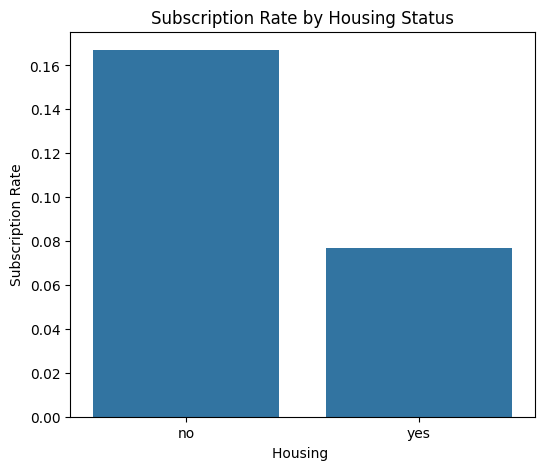

In [22]:
pct_housing_plot = pct_housing.reset_index()

plt.figure(figsize=(6,5))
sns.barplot(
    data=pct_housing_plot,
    x='housing',
    y=1
)
plt.xlabel('Housing ')
plt.ylabel('Subscription Rate')
plt.title('Subscription Rate by Housing Status')
plt.show()


### LOAN

In [23]:
cus_df['loan'].value_counts(normalize=True).round(3)

loan
no     0.84
yes    0.16
Name: proportion, dtype: float64

In [24]:
loan_target = pd.crosstab(
    cus_df['loan'],
    cus_df['target'],
    normalize='index'
).round(3)

loan_target


target,0,1
loan,,
no,0.873,0.127
yes,0.933,0.067


Text(0.5, 1.0, 'Subscription Rate by Loan')

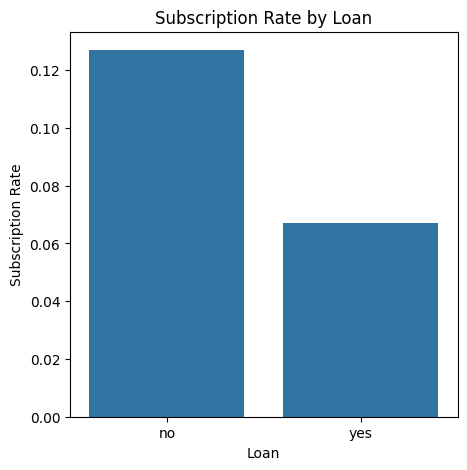

In [25]:
loan_target = loan_target.reset_index()

plt.figure(figsize=(5,5))
sns.barplot(data=loan_target, x='loan', y=1)
plt.xlabel('Loan')
plt.ylabel('Subscription Rate')
plt.title('Subscription Rate by Loan')


### Phân tích nên kết hợp biến nào

In [26]:
cat_cols = [
    'job',
    'housing',
    'loan',
    'balance_group',
    'age_group_2'
]
summary = []

for col in cat_cols:
    pct = pd.crosstab(
        cus_df[col],
        cus_df['target'],
        normalize='index'
    )[1]

    summary.append({
        'variable': col,
        'max_rate': pct.max(),
        'min_rate': pct.min(),
        'range': pct.max() - pct.min()
    })

univariate_df = (
    pd.DataFrame(summary)
    .sort_values('range', ascending=False)
)

univariate_df

,variable,max_rate,min_rate,range
0,job,0.286780,0.072750,0.214031
4,age_group_2,0.269381,0.092008,0.177373
3,balance_group,0.164496,0.051989,0.112508
1,housing,0.167024,0.077000,0.090024
2,loan,0.126557,0.066814,0.059743


In [28]:
def cis_score(var1, var2, df, target='target'):
    """
    CIS: Combined Interaction Strength
    Đo mức độ tương tác giữa 2 biến phân loại
    """
    # Range đơn biến của var1
    r1 = (
        pd.crosstab(df[var1], df[target], normalize='index')[1]
        .max()
        -
        pd.crosstab(df[var1], df[target], normalize='index')[1]
        .min()
    )

    # Range đơn biến của var2
    r2 = (
        pd.crosstab(df[var2], df[target], normalize='index')[1]
        .max()
        -
        pd.crosstab(df[var2], df[target], normalize='index')[1]
        .min()
    )

    # Range của biến kết hợp
    r12 = (
        pd.crosstab([df[var1], df[var2]], df[target], normalize='index')[1]
        .max()
        -
        pd.crosstab([df[var1], df[var2]], df[target], normalize='index')[1]
        .min()
    )

    return round(r12 - max(r1, r2), 4)


In [29]:
vars_selected = univariate_df['variable'].tolist()

cis_matrix = pd.DataFrame(
    index=vars_selected,
    columns=vars_selected,
    dtype=float
)

for x in vars_selected:
    for z in vars_selected:
        if x != z:
            cis_matrix.loc[x, z] = cis_score(x, z, cus_df)

cis_matrix


,job,age_group_2,balance_group,housing,loan
job,NaN,0.1193,0.0938,0.0842,0.0765
age_group_2,0.1193,NaN,0.1033,0.0500,0.0551
balance_group,0.0938,0.1033,NaN,0.0665,0.0116
housing,0.0842,0.0500,0.0665,NaN,0.0315
loan,0.0765,0.0551,0.0116,0.0315,NaN


Ma trận CIS cho thấy các cặp biến job × age_group_2 và age_group_2 × balance_group có mức độ tương tác cao nhất, cho thấy hành vi đăng ký tiền gửi chịu ảnh hưởng đồng thời bởi giai đoạn sự nghiệp và năng lực tài chính của khách hàng.

Ngoài ra, các cặp biến liên quan đến nghĩa vụ tài chính như job × housing và balance_group × loan cũng có CIS dương đáng kể, cho thấy tác động của thu nhập hoặc số dư tài khoản bị điều tiết bởi các khoản vay dài hạn và ngắn hạn.

Chia làm 3 nhóm:

tier1_pairs = [
    ('job', 'age_group_2'),
    ('age_group_2', 'balance_group')
]

tier2_pairs = [
    ('job', 'housing'),
    ('job', 'balance_group'),
    ('balance_group', 'housing')
]

tier3_pairs = [
    ('housing', 'loan'),
    ('age_group_2', 'loan')
]

In [30]:
import pandas as pd
import matplotlib.pyplot as plt


In [39]:
def bivariate_analysis(
    df,
    var_pairs,
    target='target'
):
    """
    df        : dataframe
    var_pairs : list of tuple [('job','housing'), ('balance_group','loan'), ...]
    target    : biến mục tiêu
    """

    n = len(var_pairs)
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(8, 4*n))
    
    if n == 1:
        axes = [axes]

    results = {}

    for idx, (v1, v2) in enumerate(var_pairs):
        # Crosstab
        ct = pd.crosstab(
            [df[v1], df[v2]],
            df[target],
            normalize='index'
        ).round(3)

        # Pivot để vẽ
        pivot_df = (
            ct
            .reset_index()
            .pivot(index=v1, columns=v2, values=1)
        )

        # Tính GAP nếu có 2 nhóm (yes/no)
        if pivot_df.shape[1] == 2:
            col1, col2 = pivot_df.columns
            pivot_df['gap'] = pivot_df[col1] - pivot_df[col2]

        # Lưu kết quả
        results[(v1, v2)] = {
            'crosstab': ct,
            'pivot': pivot_df
        }

        # Plot
        pivot_df.drop(columns='gap', errors='ignore').plot(
            kind='bar',
            ax=axes[idx]
        )

        axes[idx].set_title(f'Subscription Rate by {v1} & {v2}')
        axes[idx].set_ylabel('Subscription Rate')
        axes[idx].set_xlabel(v1)
        axes[idx].legend(title=v2)
        axes[idx].tick_params(axis='x', rotation=30)

    plt.tight_layout()
    plt.show()

    return results


In [35]:
tier1_pairs = [
    ('job', 'age_group_2'),
    ('age_group_2', 'balance_group')
]

tier2_pairs = [
    ('job', 'housing'),
    ('job', 'balance_group'),
    ('balance_group', 'housing')
]

tier3_pairs = [
    ('housing', 'loan'),
    ('age_group_2', 'loan')
]


===== TIER 1: CORE INSIGHTS =====


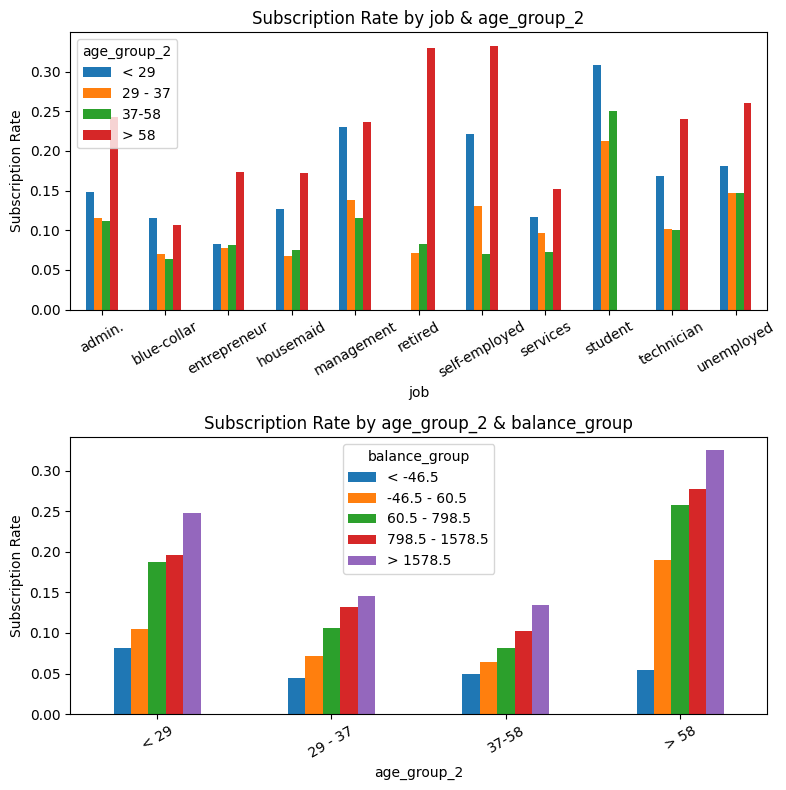

===== TIER 2: FINANCIAL CONSTRAINT =====


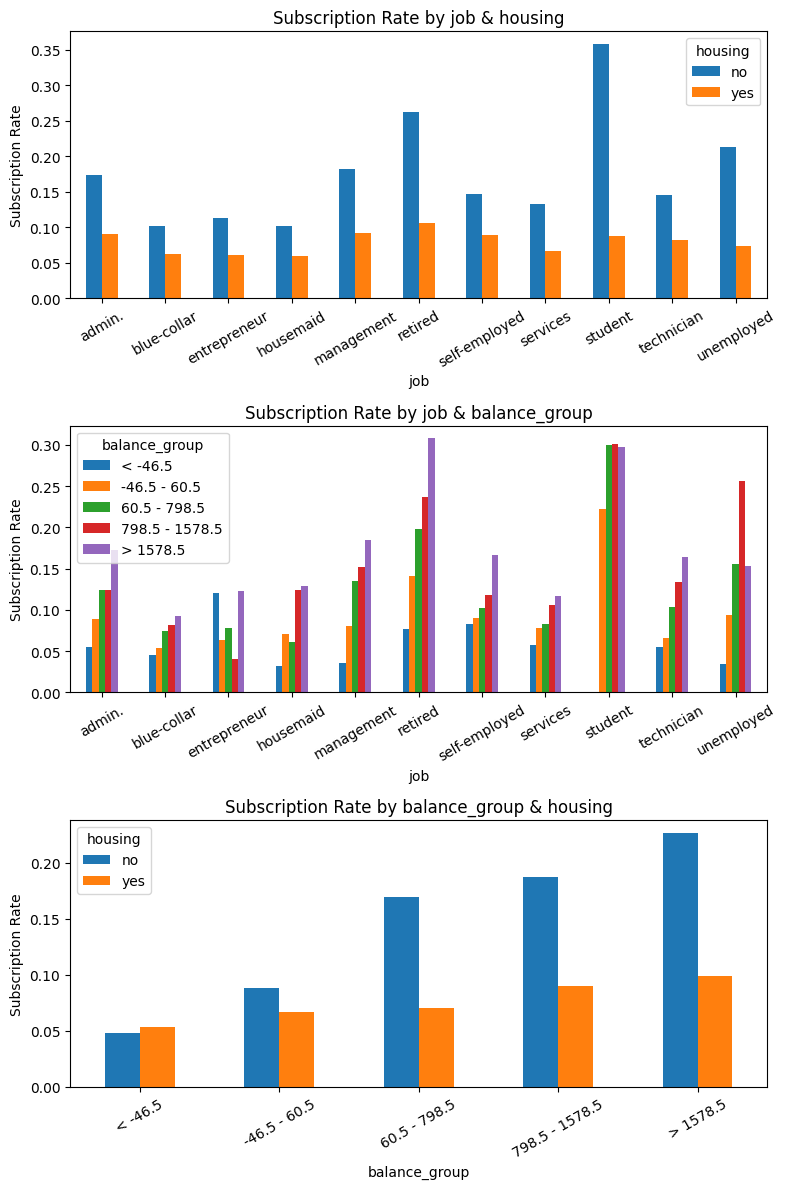

===== TIER 3: SUPPORTING ANALYSIS =====


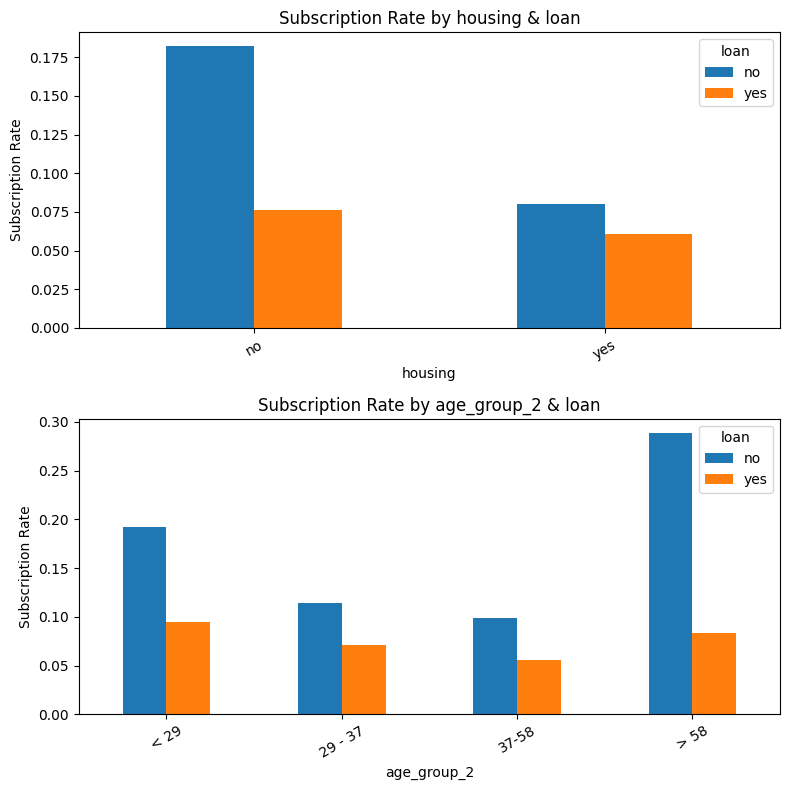

In [36]:
print("===== TIER 1: CORE INSIGHTS =====")
res_t1 = bivariate_analysis(cus_df, tier1_pairs)

print("===== TIER 2: FINANCIAL CONSTRAINT =====")
res_t2 = bivariate_analysis(cus_df, tier2_pairs)

print("===== TIER 3: SUPPORTING ANALYSIS =====")
res_t3 = bivariate_analysis(cus_df, tier3_pairs)


In [ ]:
## Hàm tính rate cho mọi tổ hợp
def compute_rate(df, group_vars, target='target'):
    rate = (
        df
        .groupby(group_vars)[target]
        .mean()
        .reset_index()
        .rename(columns={target: 'subscription_rate'})
    )
    return rate

In [ ]:
## Hàm sinh rule tự động
def generate_rules(
    df,
    group_vars,
    target='target',
    min_support=300,
    q=0.75
):
    """
    group_vars : list ['job','age_group_2'] hoặc ['age_group_2','balance_group']
    """

    global_rate = df[target].mean()
    rate_df = compute_rate(df, group_vars, target)

    # thêm support
    support = df.groupby(group_vars).size().reset_index(name='count')
    rate_df = rate_df.merge(support, on=group_vars)

    # ngưỡng rule mạnh
    threshold = rate_df['subscription_rate'].quantile(q)

    rules = rate_df[
        (rate_df['subscription_rate'] >= threshold) &
        (rate_df['count'] >= min_support)
    ].copy()

    rules['rule'] = rules.apply(
        lambda r: "IF " + " AND ".join(
            [f"{v} = {r[v]}" for v in group_vars]
        ) + f" THEN subscription_rate ≈ {round(r['subscription_rate']*100,1)}%",
        axis=1
    )

    return rules.sort_values('subscription_rate', ascending=False)


####    Job & age_group 2

In [43]:
rules_job_age = generate_rules(
    cus_df,
    group_vars=['job','age_group_2'],
    min_support=200,
    q=0.75
)

rules_job_age[['rule','count','subscription_rate']]


C:\Users\ACER\AppData\Local\Temp\ipykernel_23884\2358861224.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(group_vars)[target]
C:\Users\ACER\AppData\Local\Temp\ipykernel_23884\1751411652.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  support = df.groupby(group_vars).size().reset_index(name='count')


,rule,count,subscription_rate
23,IF job = retired AND age_group_2 = > 58 THEN s...,1331,0.329827
32,IF job = student AND age_group_2 = < 29 THEN s...,717,0.308229
19,IF job = management AND age_group_2 = > 58 THE...,342,0.236842
16,IF job = management AND age_group_2 = < 29 THE...,758,0.229551


**Với Rule 1: IF job = retired AND age_group_2 = >58 THEN subscription_rate ≈ 33%**

Nghĩa là: cứ 100 ng nghỉ hưu >58 --> 33 ng đăng ký tiền gửi 
=> Có thể do thu nhập ổn định (lương hưu), ít chi tiêu lơn, ưu tiên hoàn vốn

**Rule 2: IF job = student AND age_group_2 = <29 THEN subscription_rate ≈ 31%**

Cho thấy nhóm trẻ, chưa có thu nhập cao (<29) nhưng vẫn có xu hướng tiết kiệm mạnh
=> Có thể do chưa bị ràng buộc tài chính, ít vay nợ , dễ tiếp cận sp mới  => **Tiềm năng khách hàng dài hạn**

**Rule 3: IF job = management AND age_group_2 = >58 => subscription_rate ≈ 23.7%**

**Rule 4: IF job = management AND age_group_2 = <29 => subscription_rate ≈ 23%**

Từ Rule 3 và 4 có thể thấy cùng một nghề management nhưng >58 đăng kí nhiều hơn 

==> "NGHỀ NGHIỆP CHỈ CÓ Ý NGHĨA KHI ĐẶT CÙNG ĐỘ TUỔI" vì nhìn chung có thể ở các cặp tuổi là biến điều tiết trung tâm

**Nhìn chung thấy 2 hành vi rõ rệt :**
- Nhóm có xác xuất cao : Ngĩ hưu (>58), Sinh viên trẻ (<29>) =>ít ràng buộc tại chính, định hướng tiết kiệm rõ

- Nhóm k xuất hiện trong rule (29-58)
=> Giai đoạn chi tiêu mạnh (nhà, con cái)

#### Age_group_2 & Balance

In [44]:
rules_age_balance = generate_rules(
    cus_df,
    group_vars=['age_group_2','balance_group'],
    min_support=300,
    q=0.75
)

rules_age_balance[['rule','count','subscription_rate']]


C:\Users\ACER\AppData\Local\Temp\ipykernel_23884\2358861224.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(group_vars)[target]
C:\Users\ACER\AppData\Local\Temp\ipykernel_23884\1751411652.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  support = df.groupby(group_vars).size().reset_index(name='count')


,rule,count,subscription_rate
19,IF age_group_2 = > 58 AND balance_group = > 15...,958,0.324635
18,IF age_group_2 = > 58 AND balance_group = 798....,386,0.277202
17,IF age_group_2 = > 58 AND balance_group = 60.5...,748,0.256684
4,IF age_group_2 = < 29 AND balance_group = > 15...,875,0.248000
3,IF age_group_2 = < 29 AND balance_group = 798....,695,0.195683


**Rule 1: >58 & balance >1578.5 → 32.46%** 
=> khách hàng lớn tuổi + dư tiền cao => xác xuất đăng cao đáng kể

**Rule 2: >58 & 798.5 <banlance <1578.5 →27.7%**

**Rule 3: >58 & 60.5<balance<798.5 → 25.7%**

=> Dù balance chưa quá cao, chỉ cần>58 tuổi là xác xuất đăng kí rất cao (tuổi quan trọng hơn balance ở giai đoạn này)

**Rule 4: <29 & balance>1578.5 → 24.8%** 
=> thấp hơn 8% →cho thấy ng trẻ dù có tiền vẫn ưu tiên đầu tư, tiêu dùng hơn là tiết kiệm dài hạn

In [ ]:
## Tìm ra rule cản trở
def generate_negative_rules(
    df,
    group_vars,
    target='target',
    max_rate=0.08,
    min_support=300
):
    rate_df = compute_rate(df, group_vars, target)
    support = df.groupby(group_vars).size().reset_index(name='count')
    rate_df = rate_df.merge(support, on=group_vars)

    rules = rate_df[
        (rate_df['subscription_rate'] <= max_rate) &
        (rate_df['count'] >= min_support)
    ].copy()

    rules['rule'] = rules.apply(
        lambda r: "IF " + " AND ".join(
            [f"{v} = {r[v]}" for v in group_vars]
        ) + f" THEN subscription_rate ≈ {round(r['subscription_rate']*100,1)}%",
        axis=1
    )

    return rules.sort_values('subscription_rate')


In [49]:
generate_negative_rules(
    cus_df,
    ['age_group_2','balance_group'],
    max_rate=0.08
)[['rule','count','subscription_rate']]


C:\Users\ACER\AppData\Local\Temp\ipykernel_23884\2358861224.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(group_vars)[target]
C:\Users\ACER\AppData\Local\Temp\ipykernel_23884\3750224745.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  support = df.groupby(group_vars).size().reset_index(name='count')


,rule,count,subscription_rate
5,IF age_group_2 = 29 - 37 AND balance_group = <...,1093,0.043916
10,IF age_group_2 = 37-58 AND balance_group = < -...,1625,0.049846
11,IF age_group_2 = 37-58 AND balance_group = -46...,3649,0.063579
6,IF age_group_2 = 29 - 37 AND balance_group = -...,2691,0.072092


**NEGATIVE RULE: Trung niên + tiền thấp = gần như không tham gia**

- Dù ở độ tuổi thu nhập ổn định

- Nhưng balance thấp → không có khả năng khóa tiền

“Độ tuổi đóng vai trò điều tiết trung tâm đối với tác động của nghề nghiệp và số dư tài khoản. Các luật IF–THEN cho thấy hành vi tiết kiệm chỉ xuất hiện mạnh ở những nhóm khách hàng đã vượt qua giai đoạn chi tiêu lớn của vòng đời tài chính.”

#### Job & Housing

In [50]:
rules_job_housing = generate_rules(
    cus_df,
    group_vars=['job','housing'],
    min_support=300,
    q=0.75
)

rules_job_housing[['rule','count','subscription_rate']]


,rule,count,subscription_rate
16,IF job = student AND housing = no THEN subscri...,689,0.358491
10,IF job = retired AND housing = no THEN subscri...,1773,0.261703
20,IF job = unemployed AND housing = no THEN subs...,760,0.213158
8,IF job = management AND housing = no THEN subs...,4780,0.182008
0,IF job = admin. AND housing = no THEN subscrip...,1989,0.172951
12,IF job = self-employed AND housing = no THEN s...,814,0.146192


Có thể thấy rõ housing là rào cản tài chính mạnh, khi **housing = no**-> tỉ lệ đăng kí cao
 
 => “Kết quả cho thấy ngay cả khi có năng lực thu nhập tốt, nghĩa vụ vay mua nhà vẫn làm suy giảm đáng kể khả năng tham gia sản phẩm tiết kiệm.”

In [53]:
neg_job_housing = generate_negative_rules(
    cus_df,
    group_vars=['job', 'housing'],
    max_rate=0.08,
    min_support=300
)

neg_job_housing[['rule','count','subscription_rate']]


,rule,count,subscription_rate
7,IF job = housemaid AND housing = yes THEN subs...,398,0.060302
5,IF job = entrepreneur AND housing = yes THEN s...,869,0.060990
3,IF job = blue-collar AND housing = yes THEN su...,7048,0.061720
15,IF job = services AND housing = yes THEN subsc...,2766,0.066884
21,IF job = unemployed AND housing = yes THEN sub...,543,0.073665


🔥 Insight Housing = yes + nghề thu nhập thấp = gần như KHÔNG có hành vi tiết kiệm

“Các luật ức chế cho thấy nhóm khách hàng có nghề nghiệp thu nhập thấp và đang vay mua nhà gần như không tham gia sản phẩm tiền gửi có kỳ hạn, với tỷ lệ dưới 8%. Điều này phản ánh áp lực tài chính ngắn hạn lấn át hoàn toàn động cơ tiết kiệm.”

#### Job × Balance

In [51]:
rules_job_balance = generate_rules(
    cus_df,
    group_vars=['job','balance_group'],
    min_support=300,
    q=0.75
)

rules_job_balance[['rule','count','subscription_rate']]


C:\Users\ACER\AppData\Local\Temp\ipykernel_23884\2358861224.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(group_vars)[target]
C:\Users\ACER\AppData\Local\Temp\ipykernel_23884\1751411652.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  support = df.groupby(group_vars).size().reset_index(name='count')


,rule,count,subscription_rate
29,IF job = retired AND balance_group = > 1578.5 ...,770,0.307792
42,IF job = student AND balance_group = 60.5 - 79...,440,0.300000
28,IF job = retired AND balance_group = 798.5 - 1...,355,0.236620
27,IF job = retired AND balance_group = 60.5 - 79...,716,0.198324
24,IF job = management AND balance_group = > 1578...,2660,0.185338
4,IF job = admin. AND balance_group = > 1578.5 T...,1014,0.171598
34,IF job = self-employed AND balance_group = > 1...,401,0.167082
49,IF job = technician AND balance_group = > 1578...,1663,0.164161
52,IF job = unemployed AND balance_group = 60.5 -...,486,0.156379
54,IF job = unemployed AND balance_group = > 1578...,333,0.153153


🔥 Insight 1 – Balance không hoạt động độc lập

Số dư tài khoản chỉ làm tăng khả năng đăng ký khi nghề nghiệp gắn với ít nghĩa vụ chi tiêu trong tương lai.

🔥 Insight 2 – Job điều tiết tác động của balance

Cùng balance >1578.5:

- retired → ~31%

- management → ~18%

- admin → ~17%

🔥 Insight 3 –  với balance trung bình có hành vi giống khách hàng giàu

In [52]:
neg_job_balance = generate_negative_rules(
    cus_df,
    ['job','balance_group'],
    max_rate=0.08,
    min_support=500
)

neg_job_balance[['rule','count','subscription_rate']]


C:\Users\ACER\AppData\Local\Temp\ipykernel_23884\2358861224.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(group_vars)[target]
C:\Users\ACER\AppData\Local\Temp\ipykernel_23884\3750224745.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  support = df.groupby(group_vars).size().reset_index(name='count')


,rule,count,subscription_rate
5,IF job = blue-collar AND balance_group = < -46...,938,0.044776
6,IF job = blue-collar AND balance_group = -46.5...,1548,0.053618
45,IF job = technician AND balance_group = < -46....,577,0.055459
46,IF job = technician AND balance_group = -46.5 ...,1315,0.066160
7,IF job = blue-collar AND balance_group = 60.5 ...,4007,0.074120
12,IF job = entrepreneur AND balance_group = 60.5...,565,0.077876
36,IF job = services AND balance_group = -46.5 - ...,755,0.078146


🔥 Insight 4 – Nghề lao động + balance thấp = rào cản kép

“Phân tích cặp biến job và balance_group cho thấy số dư tài khoản không tác động đồng đều lên các nhóm nghề nghiệp khác nhau. Đối với khách hàng đã nghỉ hưu, balance cao làm tăng mạnh khả năng đăng ký tiền gửi có kỳ hạn. Ngược lại, ở các nhóm lao động phổ thông và dịch vụ, balance thấp kết hợp với đặc điểm thu nhập không ổn định tạo ra rào cản kép, khiến tỷ lệ đăng ký gần như không đáng kể.”

#### Balance & Housing

In [57]:
rules_housing_balance = generate_rules(
    cus_df,
    group_vars=['housing','balance_group'],
    min_support=300,
    q=0.75
)

rules_housing_balance[['rule','count','subscription_rate']]


C:\Users\ACER\AppData\Local\Temp\ipykernel_23884\2358861224.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(group_vars)[target]
C:\Users\ACER\AppData\Local\Temp\ipykernel_23884\1751411652.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  support = df.groupby(group_vars).size().reset_index(name='count')


,rule,count,subscription_rate
4,IF housing = no AND balance_group = > 1578.5 T...,5337,0.226719
3,IF housing = no AND balance_group = 798.5 - 15...,2816,0.187145
2,IF housing = no AND balance_group = 60.5 - 798...,7353,0.169183


🔥 Không vay nhà + có tiền dư (dù trên trugn bình) → hành vi tiết kiệm kích hoạt mạnh

In [56]:
neg_housing_balance = generate_negative_rules(
    cus_df,
    ['housing','balance_group'],
    max_rate=0.08,
    min_support=500
)

neg_housing_balance[['rule','count','subscription_rate']]


C:\Users\ACER\AppData\Local\Temp\ipykernel_23884\2358861224.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(group_vars)[target]
C:\Users\ACER\AppData\Local\Temp\ipykernel_23884\3750224745.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  support = df.groupby(group_vars).size().reset_index(name='count')


,rule,count,subscription_rate
0,IF housing = no AND balance_group = < -46.5 TH...,776,0.047680
5,IF housing = yes AND balance_group = < -46.5 T...,2417,0.053372
6,IF housing = yes AND balance_group = -46.5 - 6...,3829,0.067381
7,IF housing = yes AND balance_group = 60.5 - 79...,10224,0.070325


🔥 Bất kể housing = yes hay no, nếu balance thấp (<60.5) thì:

- Subscription rate luôn < 7%

- Chênh lệch housing KHÔNG CÒN Ý NGHĨA

=> Khi năng lực tài chính không đủ, nghĩa vụ vay nhà không còn là yếu tố phân biệt, vì hành vi tiết kiệm đã bị chặn ngay từ đầu

#### Housing & Loan

In [58]:
rules_housing_loan = generate_rules(
    cus_df,
    group_vars=['housing','loan'],
    min_support=300,
    q=0.75
)

rules_housing_loan[['rule','count','subscription_rate']]


,rule,count,subscription_rate
0,IF housing = no AND loan = no THEN subscriptio...,17204,0.182225


In [60]:
neg_housing_loan = generate_negative_rules(
    cus_df,
    ['housing','loan'],
    max_rate=0.08,
    min_support=500
)

neg_housing_loan[['rule','count','subscription_rate']]


,rule,count,subscription_rate
3,IF housing = yes AND loan = yes THEN subscript...,4367,0.060682
1,IF housing = no AND loan = yes THEN subscripti...,2877,0.076121


“housing × loan xác nhận vai trò của nghĩa vụ vay nợ như một rào cản trực tiếp đối với hành vi tiết kiệm

In [59]:
rules_age_loan = generate_rules(
    cus_df,
    group_vars=['age_group_2','loan'],
    min_support=300,
    q=0.75
)

rules_age_loan[['rule','count','subscription_rate']]


C:\Users\ACER\AppData\Local\Temp\ipykernel_23884\2358861224.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(group_vars)[target]
C:\Users\ACER\AppData\Local\Temp\ipykernel_23884\1751411652.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  support = df.groupby(group_vars).size().reset_index(name='count')


,rule,count,subscription_rate
6,IF age_group_2 = > 58 AND loan = no THEN subsc...,2312,0.288927
0,IF age_group_2 = < 29 AND loan = no THEN subsc...,4382,0.192378


- Loan = no là điều kiện cần

- Tuổi càng cao → xác suất càng tăng

Ở nhóm khách hàng lớn tuổi, việc không có nghĩa vụ vay cho phép họ ưu tiên các quyết định tiết kiệm và đầu tư an toàn.

In [61]:
neg_age_loan = generate_negative_rules(
    cus_df,
    ['age_group_2','loan'],
    max_rate=0.08,
    min_support=500
)

neg_age_loan[['rule','count','subscription_rate']]


C:\Users\ACER\AppData\Local\Temp\ipykernel_23884\2358861224.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(group_vars)[target]
C:\Users\ACER\AppData\Local\Temp\ipykernel_23884\3750224745.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  support = df.groupby(group_vars).size().reset_index(name='count')


,rule,count,subscription_rate
5,IF age_group_2 = 37-58 AND loan = yes THEN sub...,3754,0.056473
3,IF age_group_2 = 29 - 37 AND loan = yes THEN s...,2357,0.070853


- Trung niên + đang vay → tỷ lệ thấp nhất toàn bộ phân tích

“Phân tích đa biến cho thấy độ tuổi và năng lực tài chính đóng vai trò tạo động lực chính cho hành vi đăng ký tiền gửi có kỳ hạn, trong khi các nghĩa vụ vay (housing, loan) hoạt động như các yếu tố kìm hãm. Đặc biệt, khoản vay tiêu dùng làm suy giảm đáng kể khả năng tiết kiệm, nhất là ở nhóm khách hàng trung niên.”

#### DECISION TREE - XÁC NHẬN CÁC RULE TÌM ĐC

In [62]:
features = [
    'age_group_2',
    'job',
    'balance_group',
    'housing',
    'loan'
]

In [63]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

df_tree = cus_df[features + ['target']].copy()

le = LabelEncoder()
for col in features:
    df_tree[col] = le.fit_transform(df_tree[col])


X = df_tree[features]
y = df_tree['target']

tree = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=300,
    random_state=42
)

tree.fit(X, y)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",4
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",300
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current 

In [64]:
import pandas as pd

pd.Series(
    tree.feature_importances_,
    index=features
).sort_values(ascending=False)


age_group_2      0.380023
housing          0.377537
balance_group    0.158003
loan             0.081205
job              0.003232
dtype: float64

“Kết quả đo lường mức độ quan trọng của biến cho thấy AGE và HOUSING là hai yếu tố chi phối mạnh nhất hành vi đăng ký tiền gửi có kỳ hạn, chiếm hơn 75% tổng mức ảnh hưởng. Trong khi đó, JOB gần như không có tác động độc lập, mà chỉ phát huy vai trò khi kết hợp với các yếu tố nhân khẩu học và tài chính khác. Phát hiện này củng cố các insight thu được từ phân tích nhị biến và các luật IF–THEN đã trích xuất.”

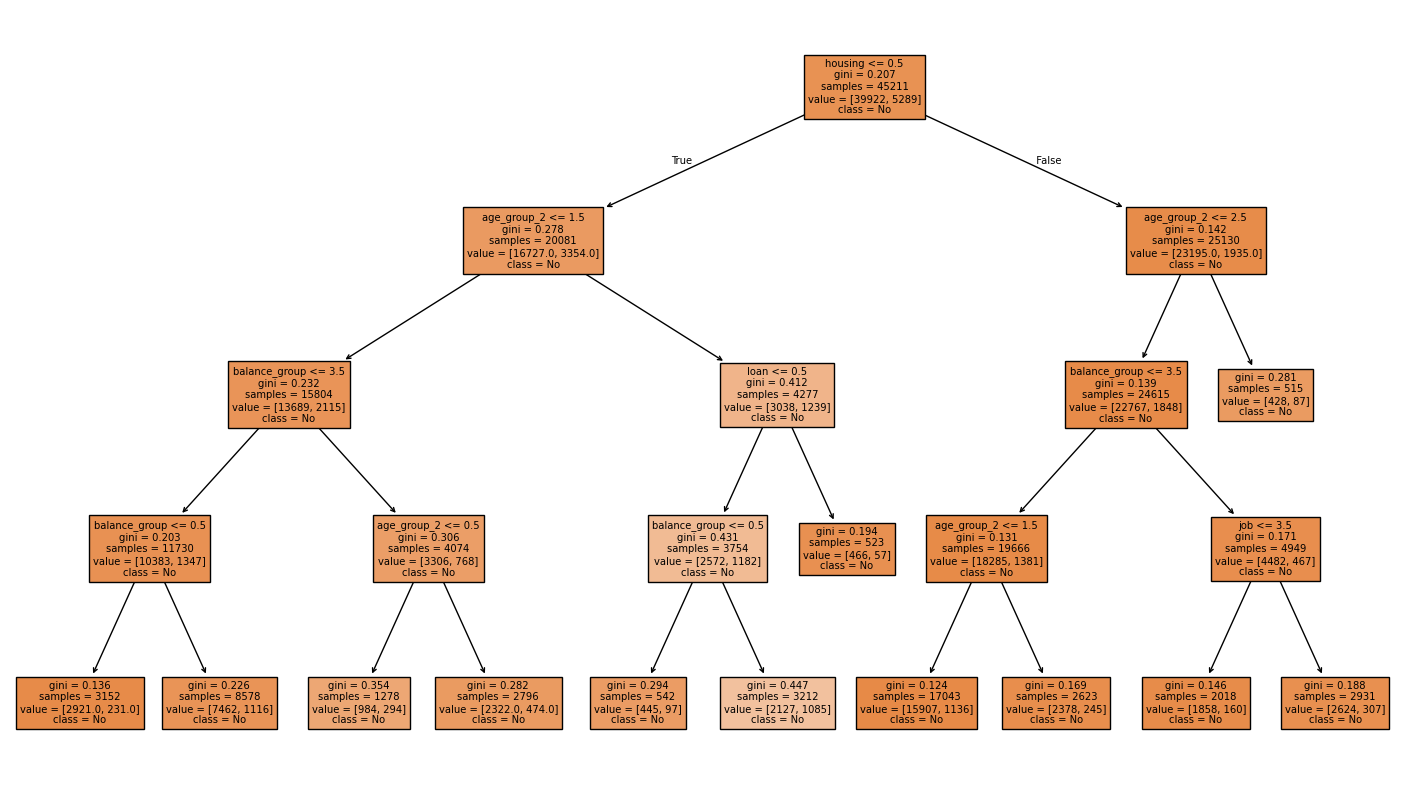

In [65]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(18,10))
plot_tree(
    tree,
    feature_names=features,
    class_names=['No','Yes'],
    filled=True
)
plt.show()


**khớp với mấy rule trên nha có thêm nhánh thứ 2 ở phần rule trên mình chưa nhìn thấy sau đc như v tại ưu tiên positive cao**

🔹 RULE 1 – NHÓM TỐT NHẤT

IF housing = no AND age_group_2 > 58 AND balance_group high THEN subscription_rate rất cao

🔹 RULE 2 – NHÓM TIỀM NĂNG NHƯNG CHƯA KHAI THÁC

IF housing = no AND age_group_2 < 29 AND balance_group trung bình THEN subscription_rate khá

🔹 RULE 3 – NHÓM YẾU NHẤT (INHIBITING SEGMENT)

IF housing = yes AND age_group_2 = 29–58 AND balance low THEN subscription_rate rất thấp

“Mô hình Decision Tree được sử dụng nhằm tổng hợp và xác nhận các phát hiện từ phân tích nhị biến và khai phá luật. Kết quả cho thấy housing là yếu tố phân tách quan trọng nhất, tiếp theo là độ tuổi và số dư tài khoản. Điều này củng cố kết luận rằng hành vi đăng ký tiền gửi chịu ảnh hưởng mạnh bởi nghĩa vụ tài chính và vòng đời tài chính của khách hàng, trong khi các đặc điểm nghề nghiệp chỉ đóng vai trò thứ yếu.”